In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_all.parquet")

/tmp/ipykernel_5065/1342149493.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cct.corr())


<Axes: >

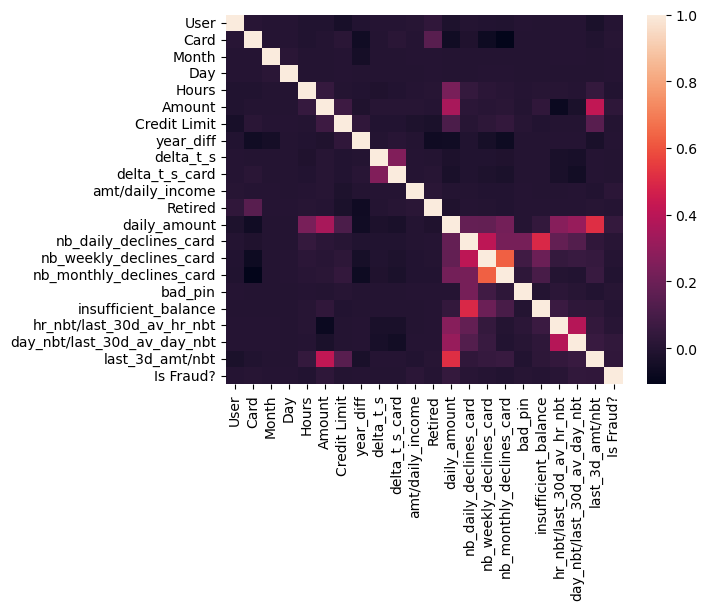

In [3]:
sns.heatmap(df_cct.corr())

In [5]:
# selecting features
# dropped Card and nb_weekly_declines_card and day_of_week
features = ['Month', 'Day', 'Hours', 'Amount', 'Use Chip',
       'Card Brand', 'Card Type', 'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt']
X = df_cct[features]
y = df_cct["Is Fraud?"]

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# using Column Transformer for RobustScaler (numerical values) and OneHotEncoder (categorical values)
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('rbscaler', RobustScaler(), ['Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'year_diff',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount',
       'nb_daily_declines_card',
       'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt']),
       ('oe', OneHotEncoder(handle_unknown="ignore"), ["Card Brand", "Card Type", "Use Chip"])
        ])
pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
X = preprocessor.fit_transform(X)

In [7]:
# splitting train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)


In [8]:
rforest = RandomForestClassifier(class_weight = "balanced")
rforest.fit(X_train,y_train)


RandomForestClassifier(class_weight='balanced')

In [9]:
# Apply model to validation data
y_pred = rforest.predict(X_test)

In [10]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

Classification metrics: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   7307143
           1       0.88      0.05      0.10      8927

    accuracy                           1.00   7316070
   macro avg       0.94      0.53      0.55   7316070
weighted avg       1.00      1.00      1.00   7316070



In [11]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

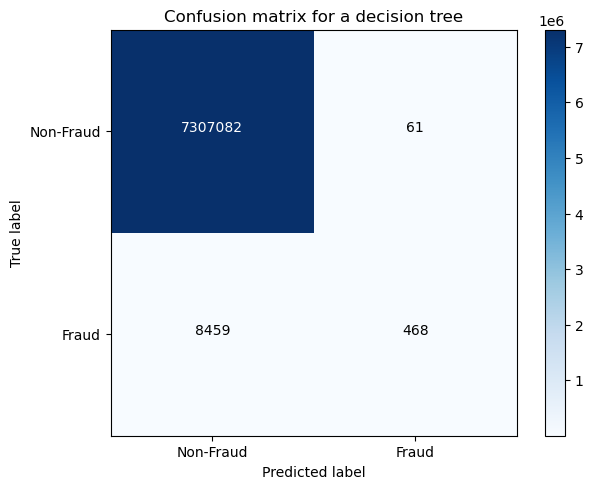

In [12]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

### Scores

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
cost = fp*15 + fn*45 - tp*45
cost

360510

In [56]:
df_score = pd.DataFrame(data = {"model" : "random_forest_balanced", "accuracy_score" : accuracy_score(y_test,y_pred),
"precision_score" : precision_score(y_test,y_pred), "recall_score" : recall_score(y_test,y_pred),
"f1_score" : f1_score(y_test,y_pred), "cost (in euros)" : cost}, index=[0, 1, 2])


In [61]:
df_score.iloc[1] = ["decision_tree_balanced", 0.997649, 0.123293, 0.151675, 0.136019,  424275]

In [60]:
df_score.iloc[2] = ["dtc_less_var_balanced",  0.997902,  0.113877,  0.106083,  0.109842, 427020]

In [62]:
df_score

,model,accuracy_score,precision_score,recall_score,f1_score,cost (in euros)
0,random_forest_balanced,0.998835,0.884688,0.052425,0.098985,360510
1,decision_tree_balanced,0.997649,0.123293,0.151675,0.136019,424275
2,dtc_less_var_balanced,0.997902,0.113877,0.106083,0.109842,427020


### Feature importance

In [ ]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'Amount', 'Use Chip',
       'Card Brand', 'Card Type', 'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'day_of_week', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Is Fraud?'],
      dtype='object')

In [15]:
X1 = ['Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'year_diff',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount',
       'nb_daily_declines_card', 
       'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt','Card Brand_Amex', 'Card Brand_Discover', 'Card Brand_Mastercard',
       'Card Brand_Visa', 'Card Type_Credit', 'Card Type_Debit',
       'Card Type_Debit (Prepaid)', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction','Retired','bad_pin', 'insufficient_balance']



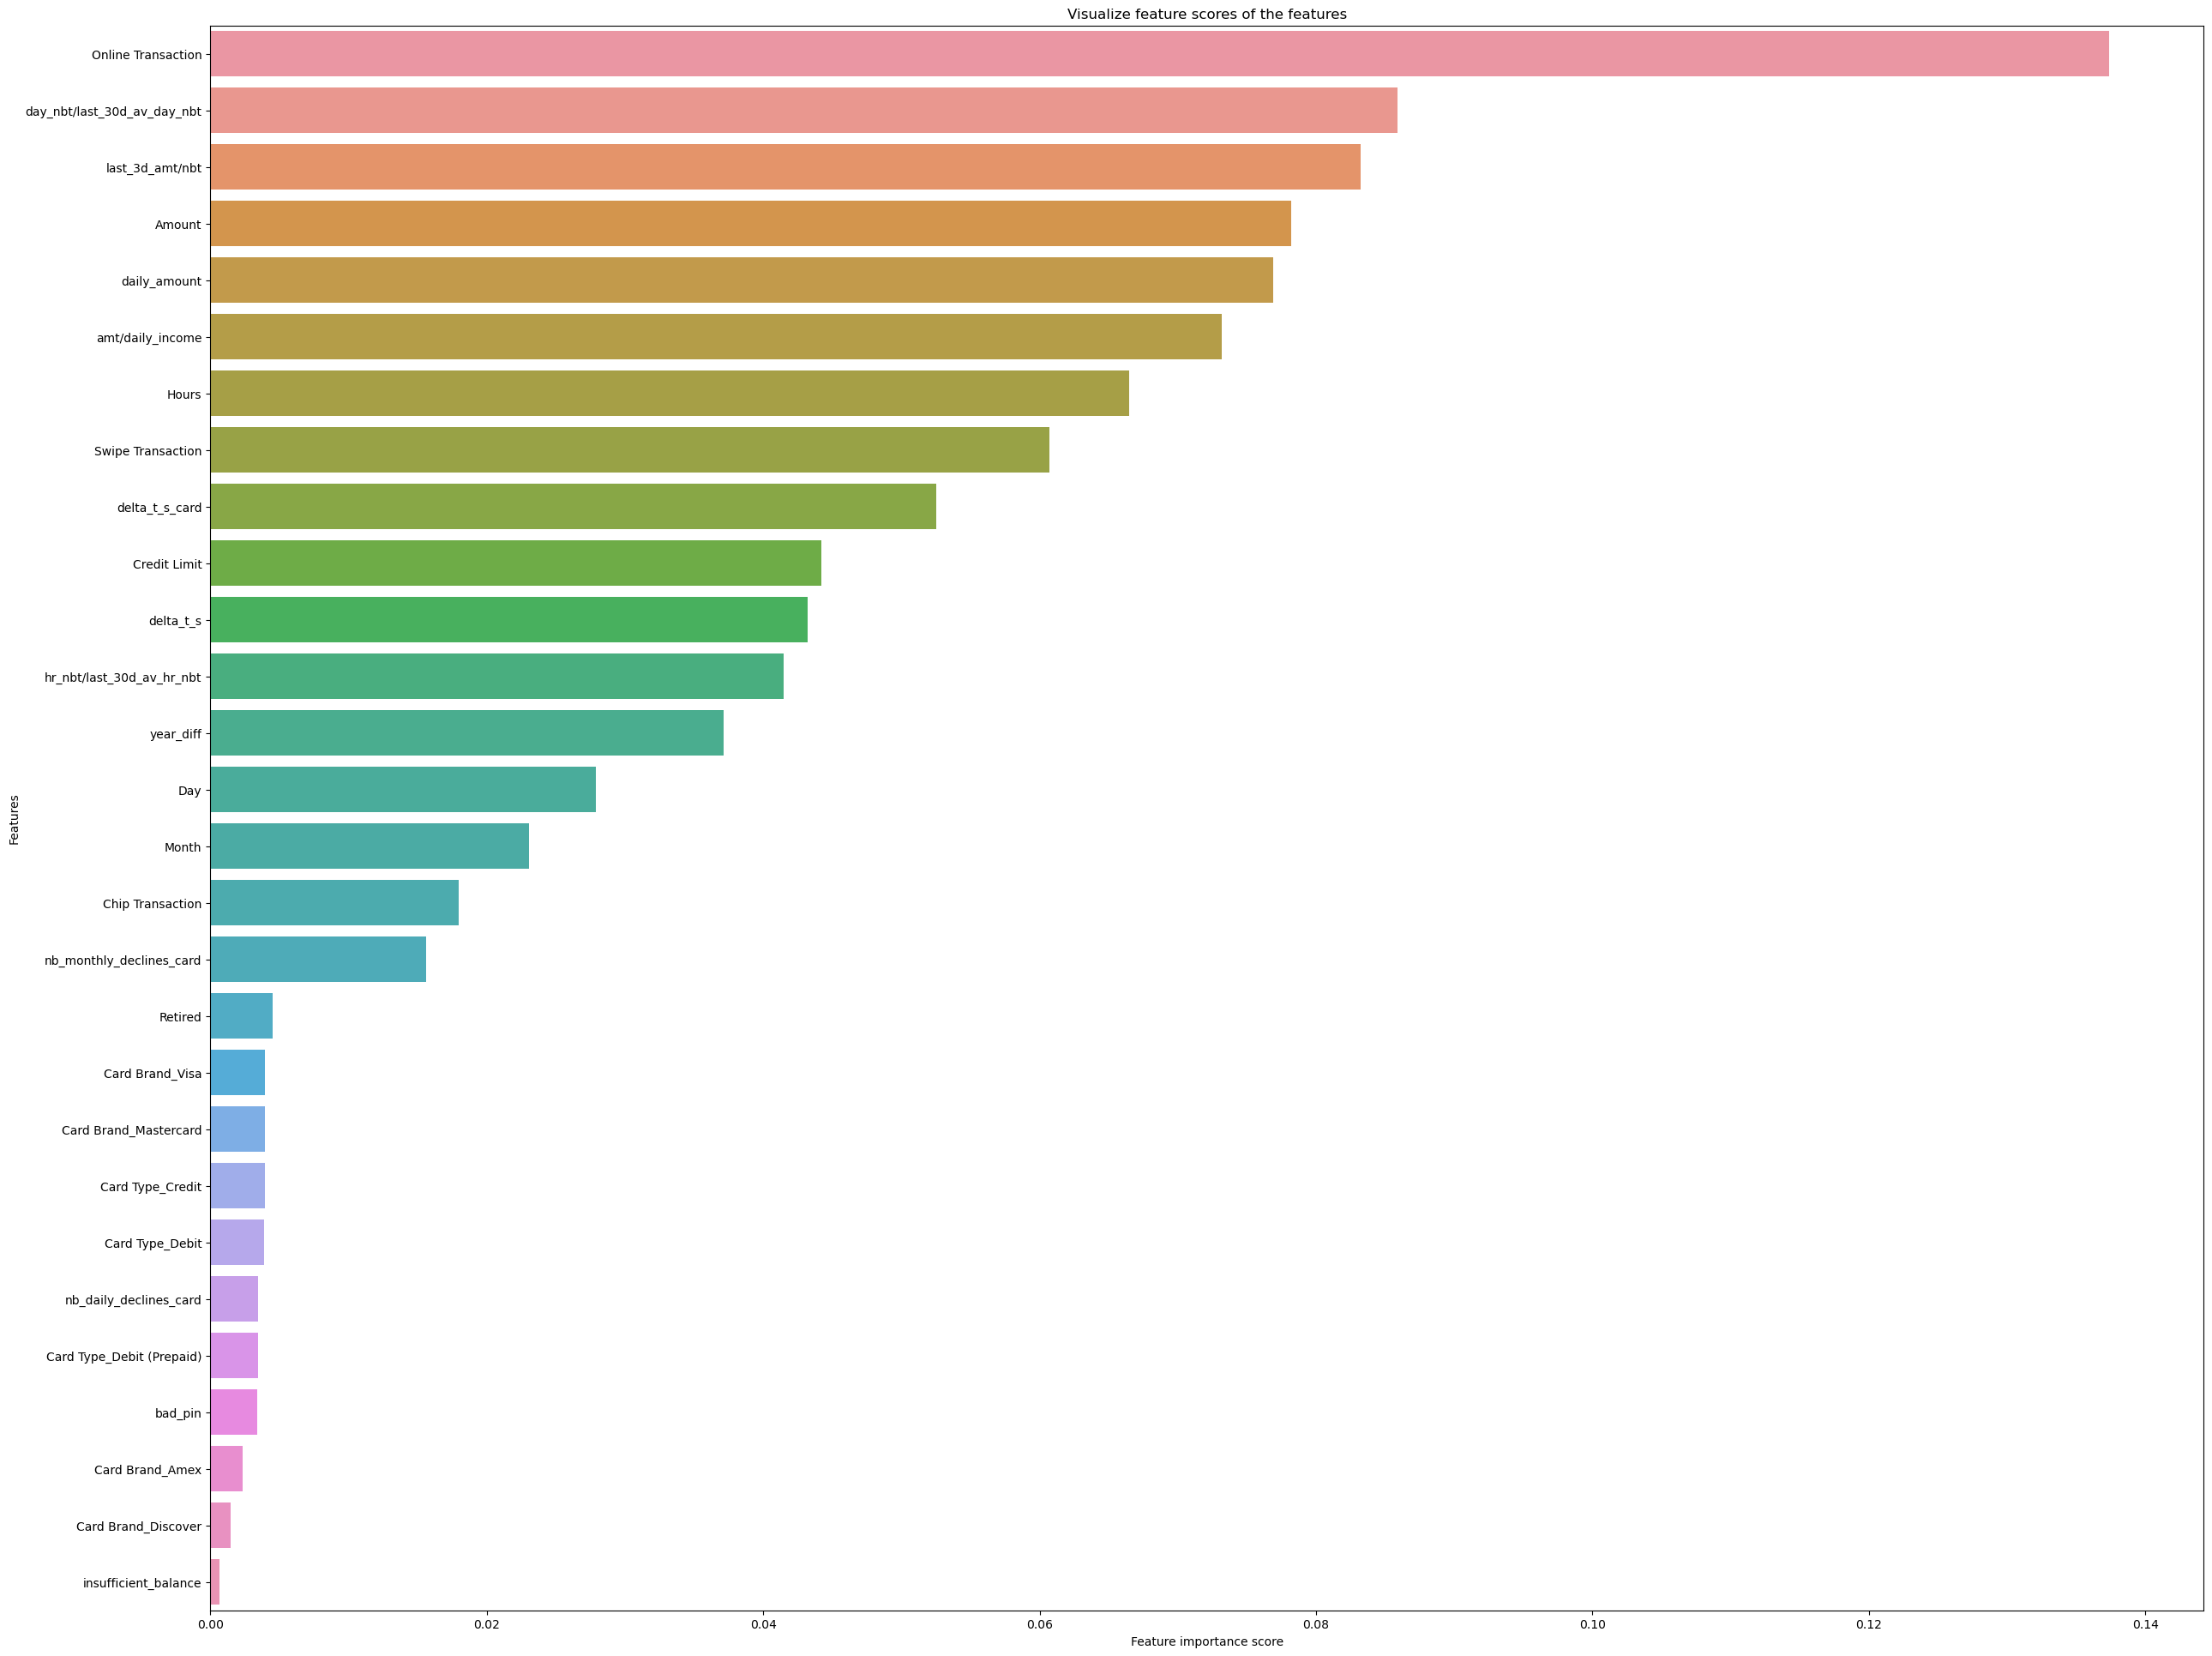

In [16]:
# view the feature scores

feature_scores = pd.Series(rforest.feature_importances_, index = X1).sort_values(ascending=False)

feature_scores

# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df_cct)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()